PS 1 - Problem 5 Solutions <br>
Inference and  Representation<br>
NYU Center for Data Science<br>
September 18, 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Given a line from a data file, returns:
# label - 0 for ham, 1 for spam
# bag   - Dict of words -> their counts (only non-zero counts)
def process_line(line):
    tokens = line.split(' ')
    label  = (tokens[1] == 'spam')
    tokens = tokens[2:] # Ignore the email index, we don't need it
    bag = {}
    for i in range(len(tokens)//2): # For each word/count pair
        word = tokens[2*i]
        count = int(tokens[2*i + 1])
        bag[word] = count
    return (label, bag)

# Given a data file, returns:
# labels - Vector of 0/1 for ham/spam per email
# bags   - List of bags of words per email
# vocab  - Vector of overall words in the vocabulary
def load_data(data_file):
    labels = []
    bags   = []
    vocab  = set()
    with open(data_file) as f:
        line = f.readline()
        while(line):
            label,bag = process_line(line)
            labels.append(label)
            bags.append(bag)
            vocab |= set(bag) # Like appending, but for sets
            line = f.readline()
    labels = np.array(labels)
    vocab  = np.array(sorted(vocab))
    return (labels,bags,vocab)

# Given bags and a vocab, returns:
# mat - A bag of words in matrix form (explicit zero values)
#     - (Rows correspond to emails, columns to words)
def bags_to_matrix(bags,vocab):
    mat = np.zeros( (len(bags),len(vocab)) )
    for i,bag in enumerate(bags):
        for j,word in enumerate(vocab):
            if word in bag:
                mat[i,j] = bag[word]
    return mat

# Returns the m-estimates given:
# X - Bag of words matrix (NxD)
# y - Vector of true classes (binary vector)
# m - Weight on the prior
# p - Prior, either scalar or 1xD
def cond_estimate(X,y,m,p):
    cond = np.zeros( (2,X_train.shape[1]) )
    ham  = X[y == 0]
    spam = X[y == 1]
    cond[0,:] = (ham.sum(axis=0) + m*p)/(ham.sum() + m)
    cond[1,:] = (spam.sum(axis=0) + m*p)/(spam.sum() + m)
    return cond

# Returns the predictive accuracy using given marginals/conditionals
def accuracy(X,y,marg,cond):
    unnorm = np.log(marg) + X.dot(np.log(cond.T))
    pred = unnorm.argmax(axis=1)
    return np.mean(y == pred)



In [2]:
#if __name__ == '__main__':
    # Load the training data
y_train,bags,vocab = load_data('data/train.txt')
X_train = bags_to_matrix(bags,vocab)

# Load the testing data
# Remember that we want to use the training vocab for testing
# (although in this case it doesn't matter since they're the same)
y_test,bags,_ = load_data('data/test.txt')
X_test = bags_to_matrix(bags,vocab)


Question b
The probability of spam is 0.574

Question c
The 5 most likely words for ham are: [ 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'enron' 'the' 'to' 'a']
The 5 most likely words for spam are: ['enron' 'a' 'corp' 'the' 'to']

Question d
The accuracy is 0.902
[0.90200000000000002, 0.90400000000000003, 0.90400000000000003, 0.871, 0.76500000000000001]


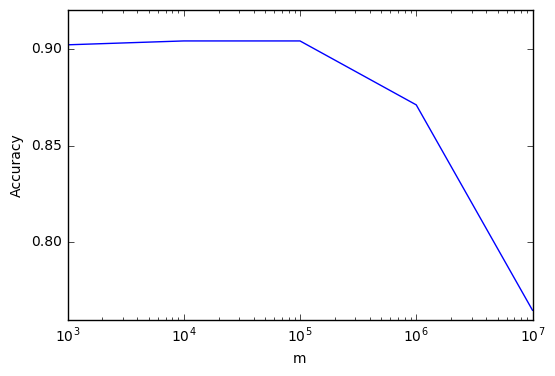

In [3]:
# Compute the marginal probabilities of spam/ham
p_spam = y_train.mean()
print ("\nQuestion b")
print ("The probability of spam is {:.3f}".format(p_spam))
marg = np.array([1 - p_spam, p_spam])

# Compute the conditional probabilities of words given spam/ham
m = len(vocab)
p = 1.0/m
cond = cond_estimate(X_train,y_train,m,p)
inds = np.argsort(-cond,axis=1)
print ("\nQuestion c")
print ("The 5 most likely words for ham are: {}".format(vocab[inds[0,:5]]))
print ("The 5 most likely words for spam are: {}".format(vocab[inds[1,:5]]))

# Compute the predictive accuracy using the current marg/cond
acc = accuracy(X_test,y_test,marg,cond)
print ("\nQuestion d")
print ("The accuracy is {:.3f}".format(acc))

# Compute the accuracies when varying m
ms = m*np.array([1,10,100,1000,10000])
accs = []
for m in ms:
    cond = cond_estimate(X_train,y_train,m,p)
    accs.append(accuracy(X_test,y_test,marg,cond))
print (accs)
plt.semilogx(ms,accs)
plt.xlabel('m')
plt.ylabel('Accuracy')
plt.show()


When $m$ is very large, we trust our empirical counts less and put more confidence into
the prior probabilities (by adding more virtual examples). In contrast, when $m$ is small
we assume that the empirical distribution is closer to the true conditional probabilities,
so we put less weight into the virtual examples. At first, increasing $m$ smooths out some
of the noise from the empirical counts and improves our accuracy, but the accuracy then
falls off quickly as our conditional probabilities approach the prior (uniform
distribution).

In order to trick the classifier, we want to artificially increase the ratio between
$P(document | ham)$ and $P(document | spam)$. We can do this by sending our original
message, followed by many repetitions of words that are more likely to occur in ham than
in spam.

<em> Acknowlegements</em> <br>
This problem and solutions are taken from University of Washington's Course CSE 446 - Machine Learning (Spring 2015)  https://courses.cs.washington.edu/courses/cse446/15sp/assignments/3/q2.py  